In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import zipfile_deflate64 as zipfile
from urllib.request import urlretrieve

from IPython.display import YouTubeVideo, display, Image

%matplotlib inline

In [17]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with zipfile.ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [18]:
URL = r"https://www.dropbox.com/s/089r2yg6aao858l/opencv_bootcamp_assets_NB14.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB14.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

### Load a Caffe Model

In [19]:
protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = os.path.join("model", "pose_iter_160000.caffemodel")

In [20]:
nPoints = 15
POSE_PAIRS = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 14],
    [14, 8],
    [8, 9],
    [9, 10],
    [14, 11],
    [11, 12],
    [12, 13],
]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

### Read Image

In [21]:
im = cv2.imread("Tiger_Woods_crop.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

inWidth = im.shape[1]
inHeight = im.shape[0]

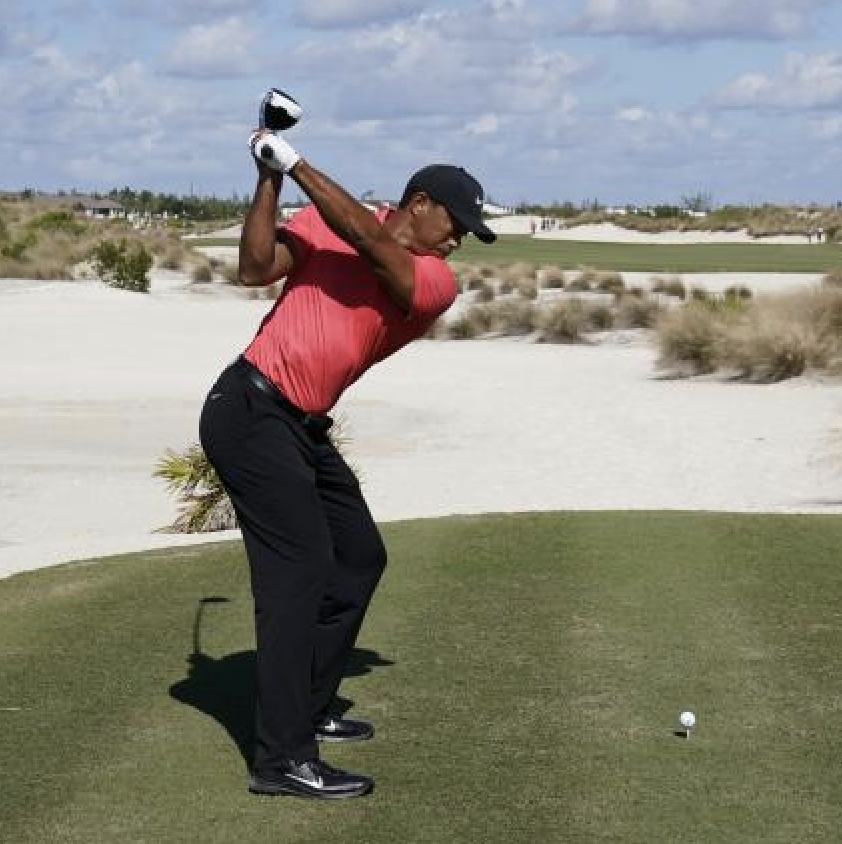

In [22]:
Image(filename="Tiger_Woods_crop.png")

### Convert image to blob

In [23]:
netInputSize = (368, 368)
inpBlob = cv2.dnn.blobFromImage(im, 1.0 / 255, netInputSize, (0, 0, 0), swapRB=True, crop=False)
net.setInput(inpBlob)

### Run Inference (forward pass)

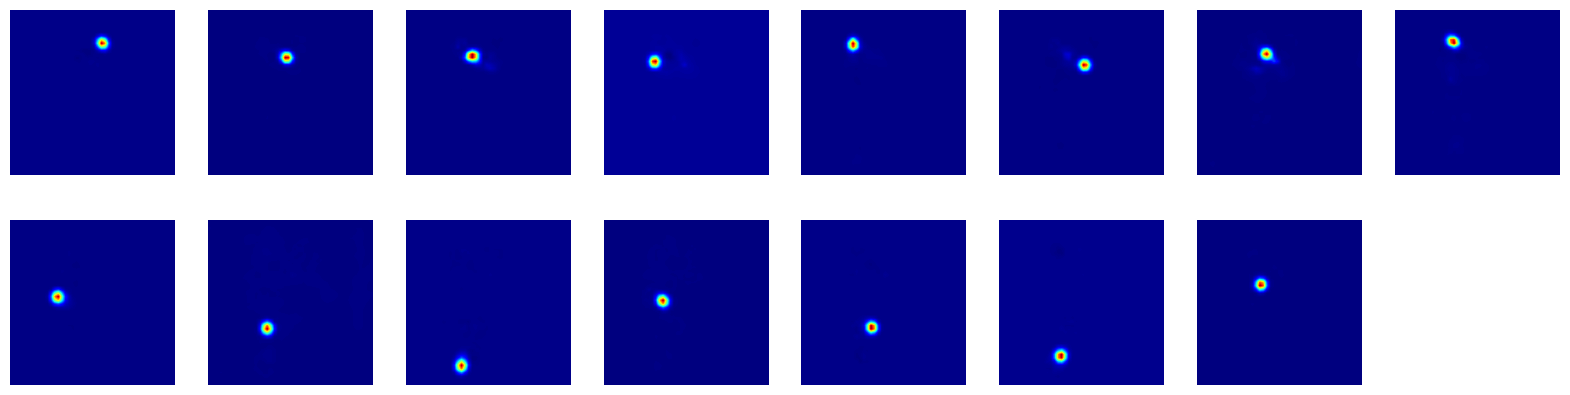

In [24]:
# Forward pass
output = net.forward()

# Display probability maps

plt.figure(figsize=(20, 5))

for i in range(nPoints):
    probMap = output[0, i, :, :]
    displayMap = cv2.resize(probMap, (inWidth, inHeight), cv2.INTER_LINEAR)

    plt.subplot(2, 8, i + 1)
    plt.axis("off")
    plt.imshow(displayMap, cmap="jet")

### Extract points

In [25]:
# X and Y Scale
scaleX = inWidth / output.shape[3]
scaleY = inHeight / output.shape[2]

# Empty list to store the detected keypoints
points = []

# Confidence treshold
threshold = 0.1

for i in range(nPoints):
    # Obtain probability map.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    # Scale the point to fit on the original image
    x = scaleX * point[0]
    y = scaleY * point[1]

    if prob > threshold:
        points.append((int(x), int(y)))
    else:
        points.append(None)

### Display Points & Skeleton

In [26]:
imPoints = im.copy()
imSkeleton = im.copy()

# Draw points
for i, p in enumerate(points):
    cv2.circle(imPoints, p, 8, (255, 255, 0), thickness=-1, lineType=cv2.FILLED)
    cv2.putText(imPoints, "{}".format(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, lineType=cv2.LINE_AA)

# Draw skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(imSkeleton, points[partA], points[partB], (255, 255, 0), 2)
        cv2.circle(imSkeleton, points[partA], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)


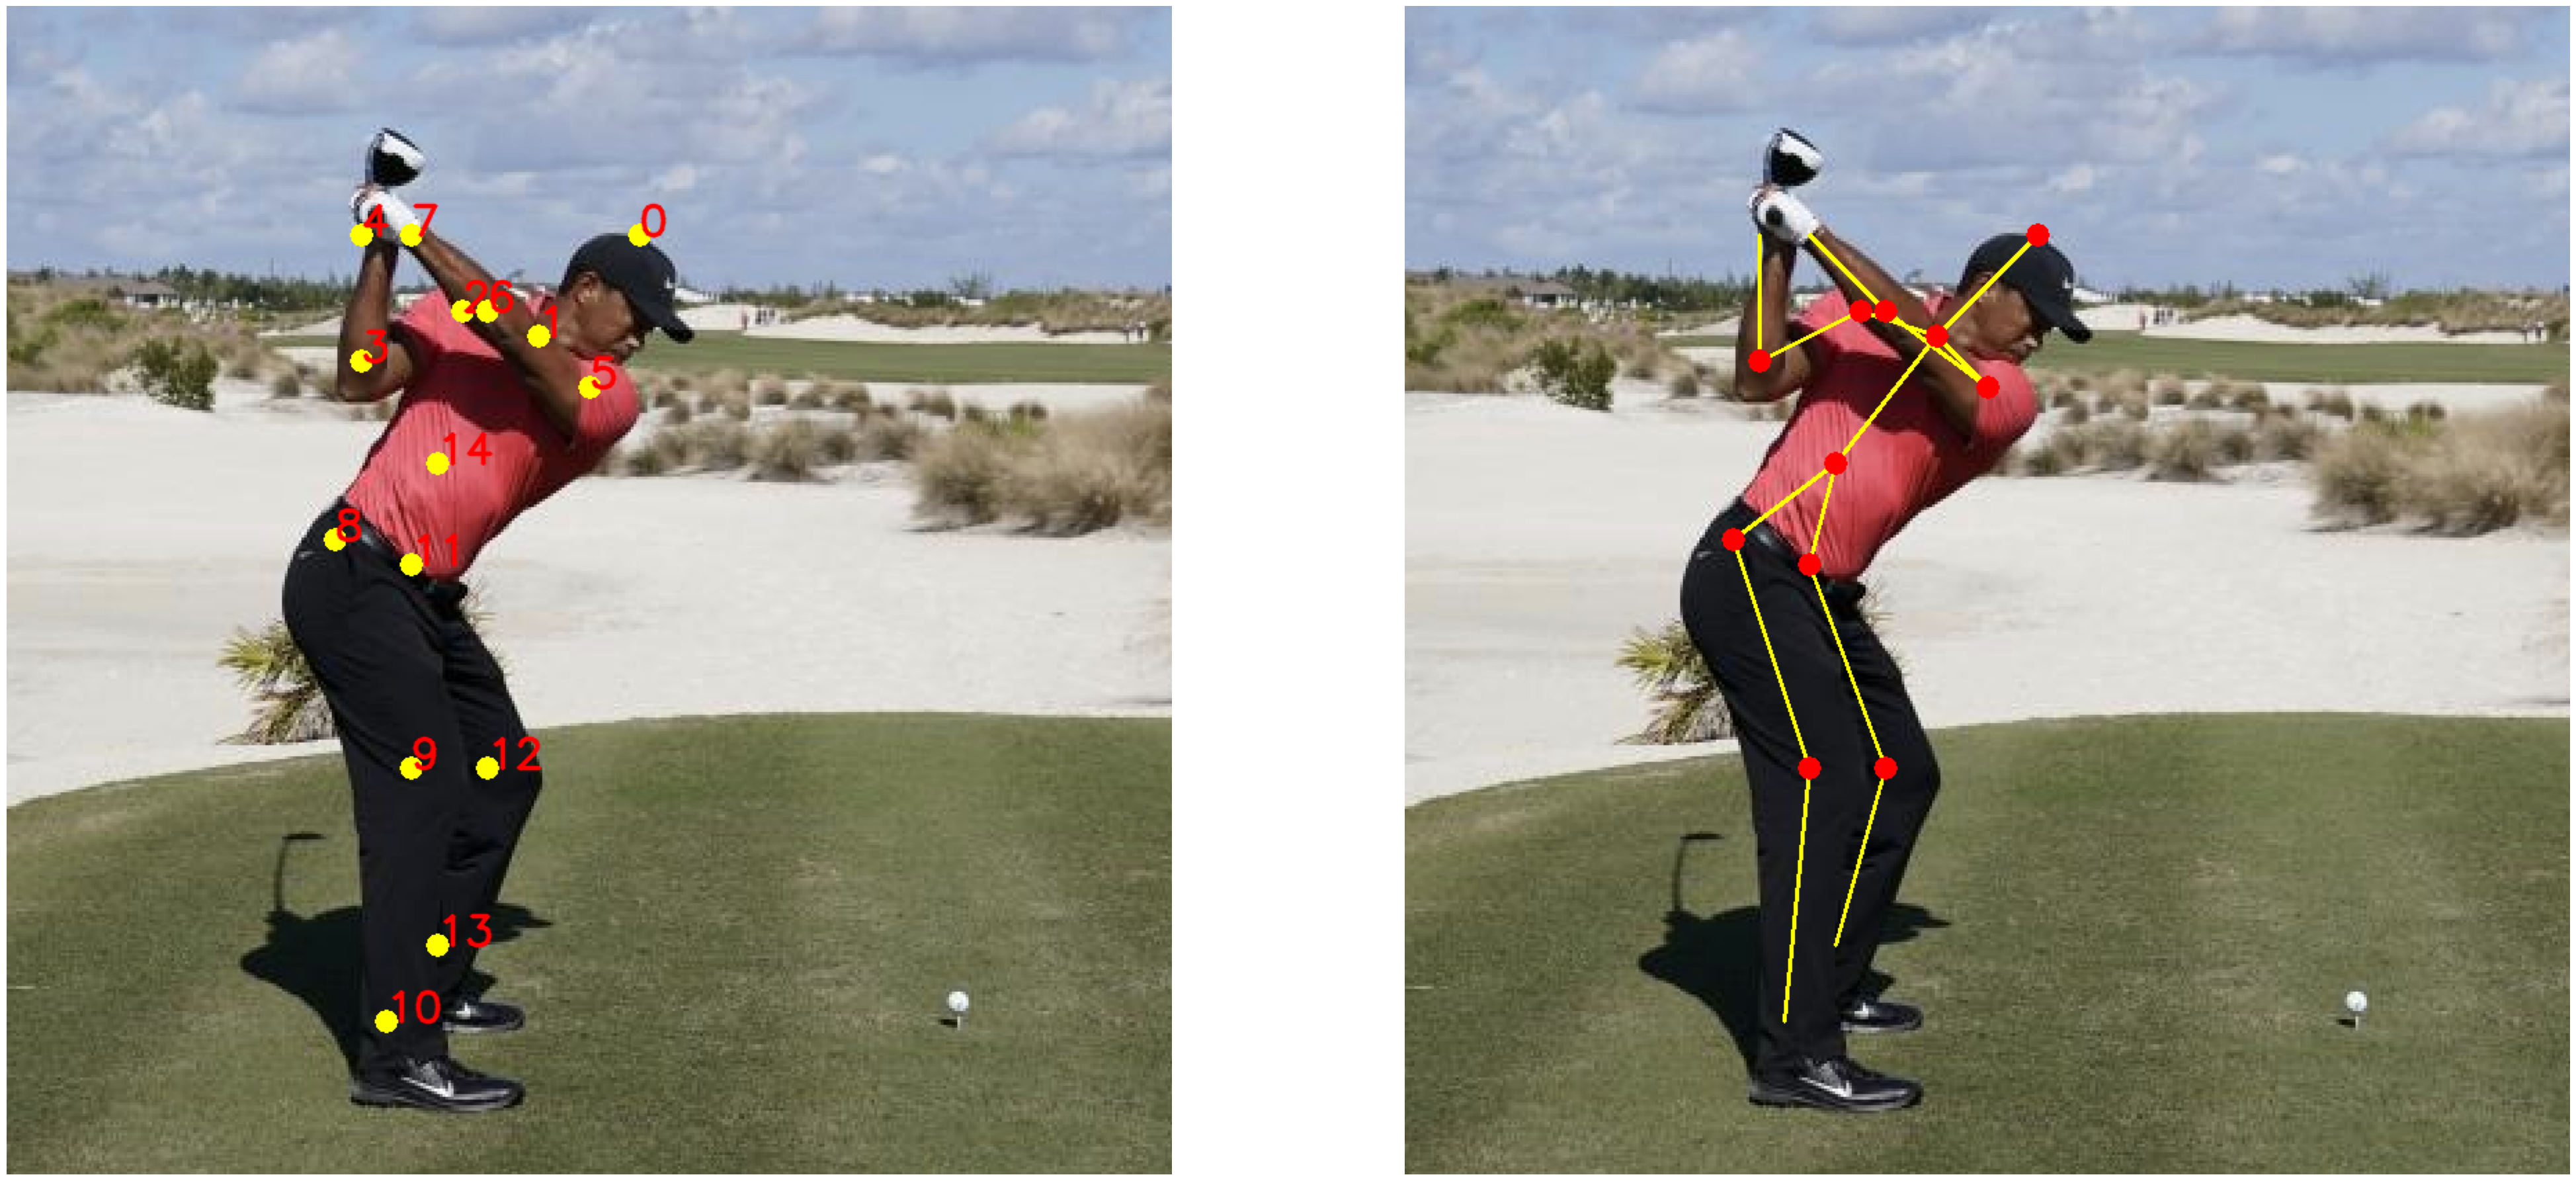

In [27]:
plt.figure(figsize=(50, 50))

plt.subplot(121)
plt.axis("off")
plt.imshow(imPoints)

plt.subplot(122)
plt.axis("off")
plt.imshow(imSkeleton)